# Homework 9

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence expect for 2, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

In [ ]:
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:


*   This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
*   The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
*   If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.

**Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleFeedForwardAttentionPoolingModel(nn.Module):
    def __init__(self, input_dim, q_dim, hidden_size):
        super(SimpleFeedForwardAttentionPoolingModel, self).__init__()
        self.ff1 = nn.Linear(input_dim, hidden_size)
        self.q = nn.Parameter(torch.randn(q_dim))
        self.Wa = nn.Linear(hidden_size, q_dim)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h1 = torch.relu(self.ff1(x))
        h2 = torch.tanh(self.Wa(h1))
        e = torch.matmul(h2, self.q)
        alpha = torch.softmax(e, dim=1)
        context_vector = torch.sum(alpha.unsqueeze(2) * h1, dim=1)
        output = self.output_layer(context_vector)
        return output

**Traning**

In [ ]:
%%time

def train(model, data, targets, epochs=500, lr=0.001, threshold=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(data)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

        if loss.item() < threshold:
            print(f"Training stopped at epoch: {epoch}, Loss: {loss.item()}")
            break

sequence_length = 50
num_samples = 1000
input_dim = 2
q_dim = 16
hidden_size = 64

# Generate data
data = []
targets = []
for _ in range(num_samples):
    seq, target = addition_problem(sequence_length)
    data.append(seq)
    targets.append(target)
data = torch.tensor(data, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Initialize and train the model
model = SimpleFeedForwardAttentionPoolingModel(input_dim, q_dim, hidden_size)
train(model, data, targets, epochs=500)

<timed exec>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


Epoch: 0, Loss: 0.6705251932144165
Epoch: 10, Loss: 0.6281407475471497
Epoch: 20, Loss: 0.626194953918457
Epoch: 30, Loss: 0.6027065515518188
Epoch: 40, Loss: 0.5329394936561584
Epoch: 50, Loss: 0.45004162192344666
Epoch: 60, Loss: 0.37415850162506104
Epoch: 70, Loss: 0.31431126594543457
Epoch: 80, Loss: 0.27119624614715576
Epoch: 90, Loss: 0.24267184734344482
Epoch: 100, Loss: 0.22456641495227814
Epoch: 110, Loss: 0.21235284209251404
Epoch: 120, Loss: 0.2025628387928009
Epoch: 130, Loss: 0.19345694780349731
Epoch: 140, Loss: 0.18463744223117828
Epoch: 150, Loss: 0.1762034147977829
Epoch: 160, Loss: 0.16833040118217468
Epoch: 170, Loss: 0.1611117571592331
Epoch: 180, Loss: 0.15452344715595245
Epoch: 190, Loss: 0.14851288497447968
Epoch: 200, Loss: 0.1429648995399475
Epoch: 210, Loss: 0.13779427111148834
Epoch: 220, Loss: 0.13286909461021423
Epoch: 230, Loss: 0.12815730273723602
Epoch: 240, Loss: 0.1235155314207077
Epoch: 250, Loss: 0.11889184266328812
Epoch: 260, Loss: 0.11436417698860

2. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

Average squared error for sequence length 50: 0.06214616441877297
Average squared error for sequence length 55: 0.07295161183144046
Average squared error for sequence length 65: 0.1079443109805652
Average squared error for sequence length 80: 0.2836637293518288
Average squared error for sequence length 100: 0.5419081193360035
Average squared error for sequence length 125: 0.7847145444673203
Average squared error for sequence length 150: 0.9544320073118433


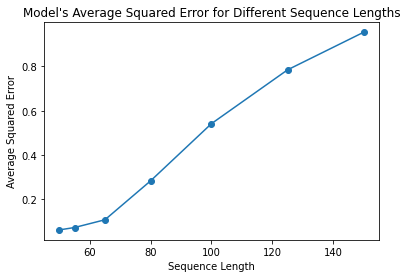

In [ ]:
import matplotlib.pyplot as plt

def evaluate(model, data, targets):
    criterion = nn.MSELoss()
    with torch.no_grad():
        predictions = model(data)
        loss = criterion(predictions, targets)
    return loss.item()

sequence_lengths = [50, 55, 65, 80, 100, 125, 150]
num_sequences = 100
averages = []

for sequence_length in sequence_lengths:
    errors = []
    for _ in range(num_sequences):
        seq, target = addition_problem(sequence_length)
        data = torch.tensor([seq], dtype=torch.float32)
        targets = torch.tensor([target], dtype=torch.float32)
        error = evaluate(model, data, targets)
        errors.append(error)
    average_error = np.mean(errors)
    averages.append(average_error)
    print(f"Average squared error for sequence length {sequence_length}: {average_error}")

plt.plot(sequence_lengths, averages, marker='o')
plt.xlabel("Sequence Length")
plt.ylabel("Average Squared Error")
plt.title("Model's Average Squared Error for Different Sequence Lengths")
plt.show()

From the plot and the observed results, we can conclude that the error increases as the sequence length increases.